In [2]:
import math
import numpy as np 
import pandas as pd 
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import ticker 
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

In [3]:
def RMSE_metric(y_true, y_pre,**kwargs):
    return mean_squared_error(y_true, y_pred, **kwargs)**0.5
RMSE = make_scorer(RMSE_metric, greater_is_better=False)

In [4]:
train = pd.read_csv('train.csv')
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [5]:
test= pd.read_csv('test.csv')
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


In [6]:
sub=pd.read_csv('sample_submission.csv')
sub.head()

,id,MedHouseVal
0,37137,2.079751
1,37138,2.079751
2,37139,2.079751
3,37140,2.079751
4,37141,2.079751


In [7]:
print(f'train set have {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test set have {test.shape[0]} rows and {test.shape[1]} columns.') 
print(f'sample_submission set have {sub.shape[0]} rows and {sub.shape[1]} columns.') 

train set have 37137 rows and 10 columns.
test set have 24759 rows and 9 columns.
sample_submission set have 24759 rows and 2 columns.


In [8]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [9]:
train.nunique()

MedInc         12310
HouseAge          51
AveRooms       22069
AveBedrms      14066
Population      3694
AveOccup       21078
Latitude         791
Longitude        755
MedHouseVal     3723
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       37137 non-null  float64
 1   HouseAge     37137 non-null  float64
 2   AveRooms     37137 non-null  float64
 3   AveBedrms    37137 non-null  float64
 4   Population   37137 non-null  float64
 5   AveOccup     37137 non-null  float64
 6   Latitude     37137 non-null  float64
 7   Longitude    37137 non-null  float64
 8   MedHouseVal  37137 non-null  float64
dtypes: float64(9)
memory usage: 2.6 MB


In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,37137.0,3.851029,1.803167,0.499900,2.602300,3.515600,4.699700,15.000100
HouseAge,37137.0,26.057005,12.158221,2.000000,17.000000,25.000000,35.000000,52.000000
AveRooms,37137.0,5.163124,1.206242,0.851064,4.357522,5.068611,5.858597,28.837607
AveBedrms,37137.0,1.062204,0.096490,0.500000,1.020305,1.054545,1.088825,5.873181
Population,37137.0,1660.778919,1302.469608,3.000000,952.000000,1383.000000,1856.000000,35682.000000
AveOccup,37137.0,2.831243,2.702413,0.950000,2.394495,2.744828,3.125313,502.990610
Latitude,37137.0,35.570030,2.083179,32.550000,33.930000,34.190000,37.700000,41.950000
Longitude,37137.0,-119.554329,1.974028,-124.350000,-121.800000,-118.450000,-118.020000,-114.550000
MedHouseVal,37137.0,2.079751,1.158571,0.149990,1.208000,1.808000,2.660000,5.000010


In [12]:
def read_gpd(df):
    df = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
        crs=4326
    ).to_crs(epsg=3857)

    df.Longitude = df.geometry.x
    df.Latitude = df.geometry.y
    
    return df

In [13]:
from sklearn.datasets import fetch_california_housing as fch

# original_df = pd.DataFrame(fch()['data'], columns=fch()['feature_names'])
# original_df['MedHouseVal'] = fch()['target']

df = read_gpd(pd.read_csv('train.csv', index_col=0))
df_test = read_gpd(pd.read_csv('test.csv', index_col=0))

x_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
y_col = 'MedHouseVal'

display(df.sample(10))
df.info()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,geometry
id,,,,,,,,,,
20505,4.0227,15.0,5.948529,1.058824,2710.0,2.887255,4.674512e+06,-1.349860e+07,1.57300,POINT (-13498601.454 4674511.536)
10794,2.6333,23.0,5.274011,1.171103,827.0,2.596958,4.026117e+06,-1.317244e+07,1.13900,POINT (-13172435.346 4026116.831)
18257,0.9379,19.0,2.457547,1.000000,631.0,1.880342,3.868787e+06,-1.286408e+07,0.55900,POINT (-12864080.356 3868787.298)
8724,2.9750,46.0,5.049669,1.049669,562.0,2.847458,4.402928e+06,-1.333607e+07,0.94600,POINT (-13336074.997 4402927.838)
10722,5.1781,26.0,6.045902,1.000000,1056.0,2.696721,3.907256e+06,-1.304998e+07,2.30000,POINT (-13049983.906 3907256.060)
29719,6.5515,26.0,6.735798,1.012235,1507.0,2.124022,4.554029e+06,-1.360658e+07,3.07000,POINT (-13606581.360 4554028.963)
20276,7.8167,33.0,7.138756,1.087977,349.0,2.094395,4.575189e+06,-1.364220e+07,5.00001,POINT (-13642203.597 4575188.685)
25246,5.1702,24.0,5.335526,1.061408,731.0,2.504673,4.482405e+06,-1.357875e+07,2.59800,POINT (-13578751.487 4482405.328)
18120,3.4464,19.0,5.769570,1.037428,2413.0,2.844371,4.024774e+06,-1.308004e+07,1.28100,POINT (-13080040.168 4024774.470)


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   MedInc       37137 non-null  float64 
 1   HouseAge     37137 non-null  float64 
 2   AveRooms     37137 non-null  float64 
 3   AveBedrms    37137 non-null  float64 
 4   Population   37137 non-null  float64 
 5   AveOccup     37137 non-null  float64 
 6   Latitude     37137 non-null  float64 
 7   Longitude    37137 non-null  float64 
 8   MedHouseVal  37137 non-null  float64 
 9   geometry     37137 non-null  geometry
dtypes: float64(9), geometry(1)
memory usage: 3.1 MB


<AxesSubplot: xlabel='MedHouseVal', ylabel='Count'>

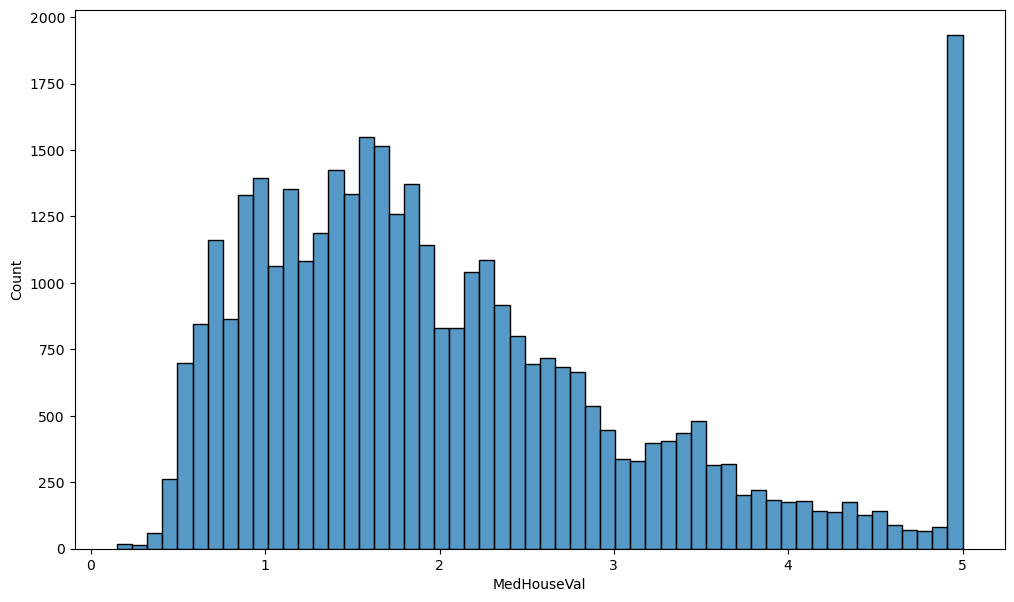

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(data= df,x=y_col,ax=ax)

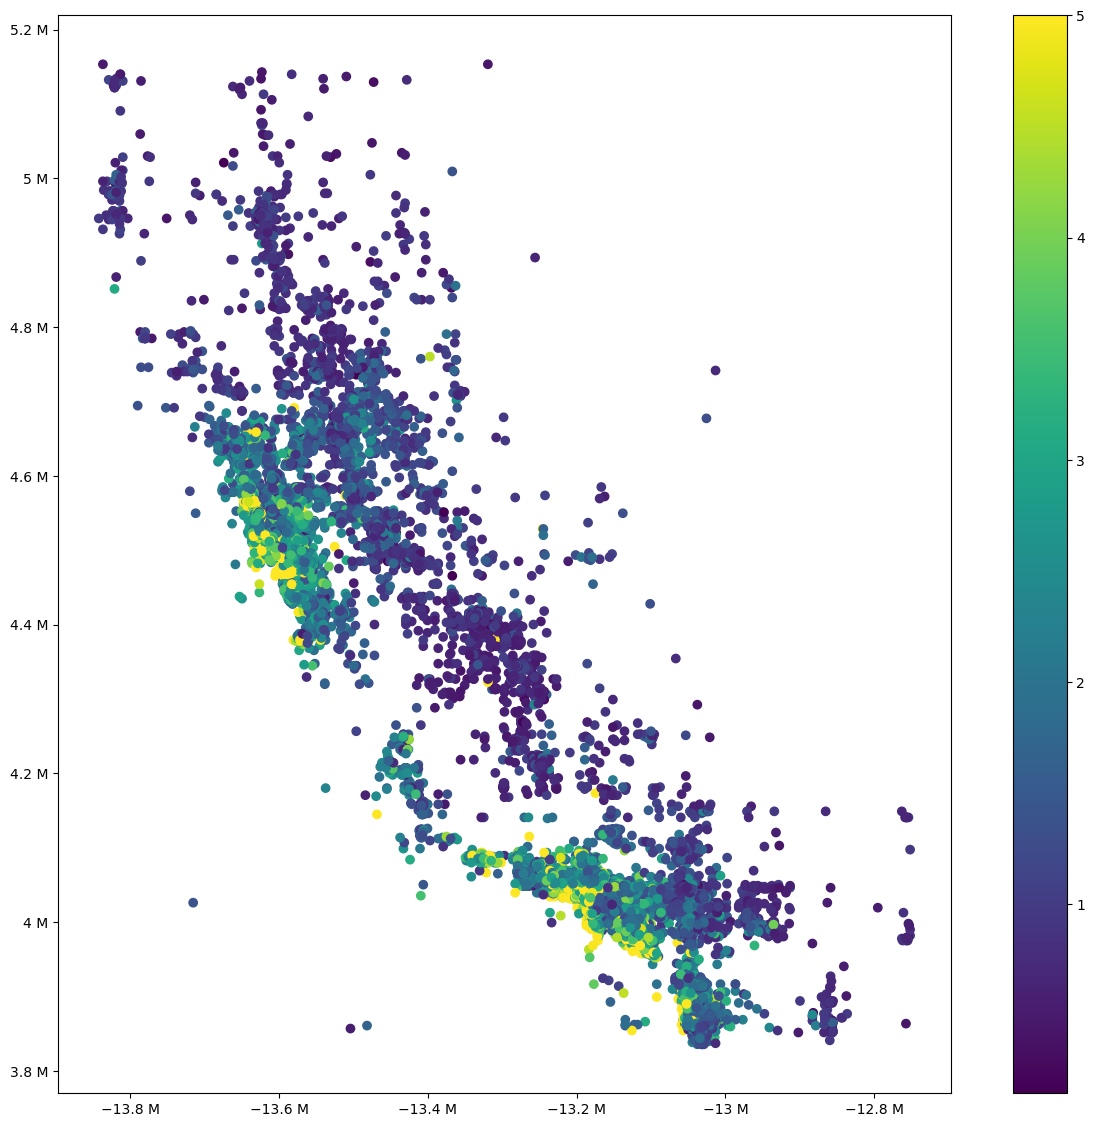

In [15]:
fig, ax = plt.subplots(1,1,figsize=(16,14))
df_buffer = df.copy()
df_bufffer = df_buffer.geometry.buffer(1e3)

df_buffer.plot(column='MedHouseVal',
               legend=True,
               ax=ax);

ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [16]:
import folium
from folium.plugins import HeatMap
heat_map = folium.Map(train[['Latitude','Longitude']].mean(axis=0),zoom_start=6)
train['Latitude']=train['Latitude'].astype(float)
train['Longitude']=train['Longitude'].astype(float)

lat_long_list = [[row['Latitude'],row['Longitude']] for index, row in train.iterrows()]
HeatMap(lat_long_list, radius=10).add_to(heat_map)
heat_map

c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: vmin. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


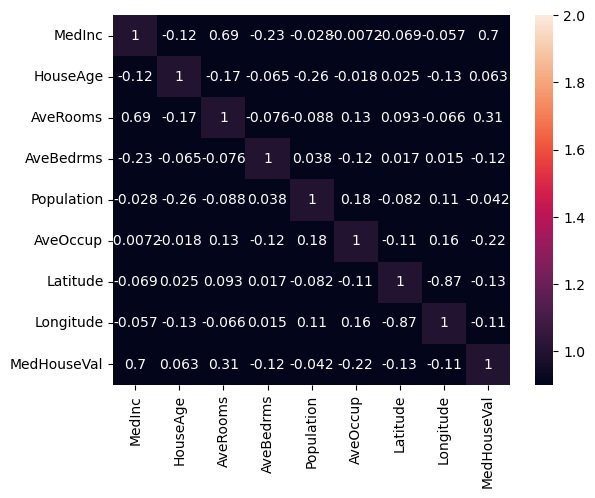

In [17]:
fig, ax = plt.subplots(1,1)
sns.heatmap(df[x_cols+[y_col]]
.corr(method ='spearman'),round(2),annot=True,ax=ax);


XBGOOST


In [18]:
X = train.drop('MedHouseVal', axis=1)
Y=train['MedHouseVal']

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

folds = KFold(n_splits=5,shuffle=True)
for fold, (trn_idx,val_idx) in enumerate(folds.split(X)):
    print(f"Fold:{fold}")
    X_train,X_test = X.iloc[trn_idx],X.iloc[val_idx]
    Y_train, Y_test=Y.iloc[trn_idx],Y.iloc[val_idx]
    model = XGBRegressor(n_estimators = 2023,learning_rate =0.01)
    model.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100,verbose=False)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(Y_test,y_pred,squared = False)

    print(f"RMSE:{rmse}")
    print("-"*50)

Fold:0


c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE:0.5637259453990485
--------------------------------------------------
Fold:1


c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE:0.5750856458004485
--------------------------------------------------
Fold:2


c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE:0.5853331489612829
--------------------------------------------------
Fold:3


c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE:0.5661441336729756
--------------------------------------------------
Fold:4


c:\Users\admin\anaconda3\envs\base1\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE:0.5647178832015687
--------------------------------------------------


In [20]:
sub['MedHouseVal'] = model.predict(test)
print(sub['MedHouseVal'])

0        0.659328
1        0.998741
2        4.006763
3        3.305366
4        2.472332
           ...   
24754    2.248132
24755    2.006271
24756    1.239477
24757    3.782101
24758    3.897053
Name: MedHouseVal, Length: 24759, dtype: float32
